In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs               
import cartopy.feature as cfeature         
from cartopy.util import add_cyclic_point  
import xarray as xr                        
import numpy as np 
import pandas as pd
import xesmf as xe
import plotting_module

In [2]:
ozone_dataset = xr.open_dataset("/glade/campaign/acom/acom-climate/UTLS/shawnh/archive/FCnudged_f09.mam.mar27.2000_2021.002/atm/proc/tseries/month_1/FCnudged_f09.mam.mar27.2000_2021.002.cam.h0.O3.200201-202412.nc")
pdeldry_dataset = xr.open_dataset("/glade/campaign/acom/acom-climate/UTLS/shawnh/archive/FCnudged_f09.mam.mar27.2000_2021.002/atm/proc/tseries/month_1/FCnudged_f09.mam.mar27.2000_2021.002.cam.h0.PDELDRY.200201-202412.nc")
ps_dataset = xr.open_dataset('/glade/campaign/acom/acom-climate/UTLS/shawnh/archive/FCnudged_f09.mam.mar27.2000_2021.002/atm/proc/tseries/month_1/FCnudged_f09.mam.mar27.2000_2021.002.cam.h0.PS.200201-202412.nc')

In [3]:
ozone = ozone_dataset["O3"]
lat = ozone.coords['lat']
lon = ozone.coords['lon']

Calculating pressure at every hybrid level

p(k) = a(k) * p0 + b(k) * ps

In [4]:
p0 = ozone_dataset["P0"]
hyai = ozone_dataset["hyai"]
hybi = ozone_dataset["hybi"]
ps = ps_dataset['PS']
lev = ozone_dataset.coords['lev']
num_lev = lev.shape[0]
pdeldry = pdeldry_dataset['PDELDRY']

# convert to hPa from Pa
pdeldry = pdeldry.copy() / 100 

# truncate to levels 16-31
truncated_pdeldry = pdeldry.isel({pdeldry.dims[1]: slice(16, 31)})
truncated_ozone = ozone.isel({ozone.dims[1]: slice(16, 31)})

Now changing 'ozone' and 'pdeldry' DataArrays into grouped by months one, just to see what it looks like as a plot for the 12 months.

In [5]:
start_date = '2005-02-01'

# group the 240 month dates based on calendar months for both PDELDRY and O3 variables

truncated_pdeldry = truncated_pdeldry.sel(time=slice(start_date,'2025-01-01'))
pdeldry_monthly_mean = truncated_pdeldry.groupby('time.month').mean('time')

truncated_ozone = truncated_ozone.sel(time=slice(start_date,'2025-01-01'))
ozone_monthly_mean = truncated_ozone.groupby('time.month').mean('time')

In [6]:
# constants / conversion factor
NAv = 6.0221415e+23                       # molecules in mole
g = 9.81                                  # gravity
MWair = 28.94                             # g/mol
xp_const = (NAv * 10)/(MWair*g)           # scaling factor, pa to hPa and cm to m
DU_CONVERSION = 2.69 * 10**16

In [7]:
#mod_press thing

In [8]:
ozone_column = xr.dot(pdeldry_monthly_mean, xp_const*ozone_monthly_mean, dims='lev')

# calculate pdeldry with hybrid pressure levels, should be same
#check pn > 300 hpa
# |Pn - 300| = delta p
# if 300 - 250hpa (in upper) is negative: then there is an error, 300 somewhere up in the atmosphere

In [9]:
ozone_du_column = ozone_column.copy() / DU_CONVERSION

# average over months from 2005-2024, find highest level interfaces (16-31)

In [10]:
omi_mls_ds = xr.open_dataarray("/glade/u/home/mvoncyga/SOARS_2025/OMIMLS_300hpa_monthly_mean_2005_2024.nc")
omi_mls_ds = omi_mls_ds.rename({'latitude': 'lat', 'longitude': 'lon'})

# shifting lon to be 0-360
omi_mls_ds['lon'] = omi_mls_ds['lon'] % 360
omi_mls_ds = omi_mls_ds.sortby('lon')
omi_mls_ds

<xarray.DataArray 'TropoO3' (month: 12, lat: 180, lon: 360)> Size: 3MB
[777600 values with dtype=float32]
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Attributes:
    units:      Dobson Units
    name:       Tropospheric Ozone, Ground to 300 hPa
    latitude:   -89.5, -88.5, ..., 89.5
    longitude:  -179.5, -178.5, ..., 179.5

In [11]:
ozone_du_column_regridded = ozone_du_column.interp(coords=dict(lat=omi_mls_ds.lat, lon=omi_mls_ds.lon), method='cubic')
ozone_du_column_regridded

<xarray.DataArray (month: 12, lat: 180, lon: 360)> Size: 6MB
array([[[18.08150734, 18.08048231, 18.07931759, ..., 18.08424061,
         18.08311636,         nan],
        [18.17514313, 18.17035776, 18.16527338, ..., 18.18832714,
         18.18383716,         nan],
        [18.22623415, 18.21819845, 18.21035435, ..., 18.25046359,
         18.24272766,         nan],
        ...,
        [32.48394945, 32.4815463 , 32.47946557, ..., 32.4934121 ,
         32.48995222,         nan],
        [32.53501966, 32.53173672, 32.5283892 , ..., 32.54418025,
         32.54125962,         nan],
        [32.57084715, 32.56956829, 32.56834185, ..., 32.57503105,
         32.57356347,         nan]],

       [[20.98275235, 20.98209361, 20.9810532 , ..., 20.98421571,
         20.983454  ,         nan],
        [21.05926246, 21.05582483, 21.05188183, ..., 21.06937153,
         21.06563771,         nan],
        [21.09737683, 21.09085387, 21.08419431, ..., 21.11641543,
         21.11033428,         nan],
...
        [32.70697819, 32.7039736 , 32.70108084, ..., 32.71557755,
         32.71283643,         nan],
        [32.80761154, 32.80541849, 32.80324806, ..., 32.81479317,
         32.81241766,         nan],
        [32.91862364, 32.9174246 , 32.91625563, ..., 32.92276756,
         32.92133522,         nan]],

       [[15.04218378, 15.04100802, 15.03960216, ..., 15.04490013,
         15.04386486,         nan],
        [15.25048509, 15.24721298, 15.24349446, ..., 15.2593044 ,
         15.25613569,         nan],
        [15.42995249, 15.42538463, 15.42115012, ..., 15.44493405,
         15.44000265,         nan],
        ...,
        [32.55846136, 32.55172146, 32.54510017, ..., 32.57934505,
         32.57221523,         nan],
        [32.68121863, 32.6777829 , 32.67429787, ..., 32.69168213,
         32.68811315,         nan],
        [32.77834945, 32.77675982, 32.77525294, ..., 32.78361839,
         32.78182801,         nan]]])
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5

In [12]:
month_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

#for i in range(12):
#    plotting_module.plotting_ozone(ozone_du_column_regridded, i, "CESM Tropospheric Ozone: ", month_list[i], "2005 - 2024")

In [13]:
#ozone_du_column = ozone_du_column.rename({'lat': 'latitude', 'lon': 'longitude'})
#ozone_du_column = ozone_du_column.transpose('month', 'longitude', 'latitude')

AttributeError: Line2D.set() got an unexpected keyword argument 'vmin'

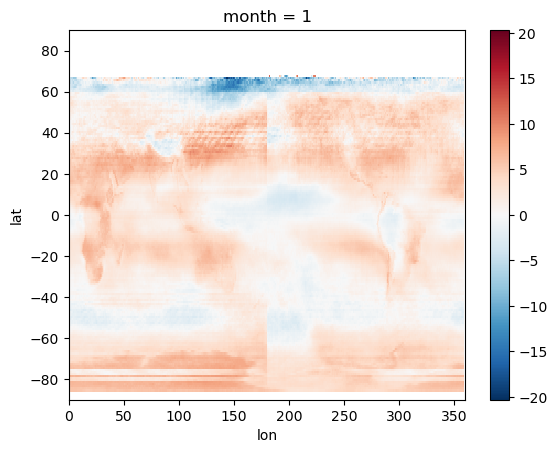

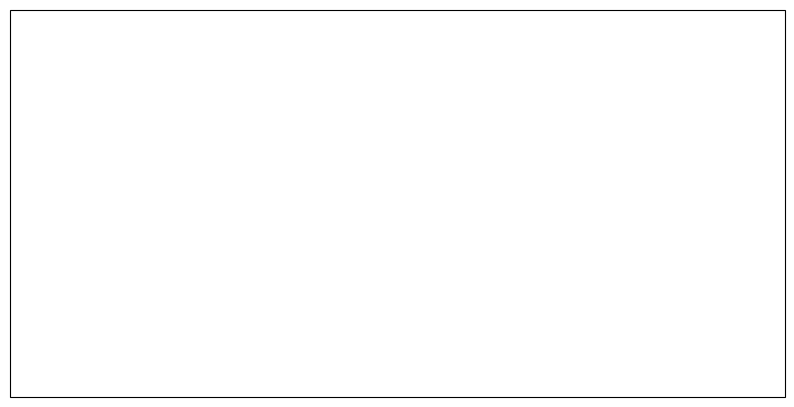

In [21]:
difference = ozone_du_column_regridded[0] - omi_mls_ds[0]
difference.plot()

plotting_module.plotting_ozone(difference, 0, "CESM Tropospheric Ozone: ", month_list[0], "2005 - 2024")